## Multi Head Attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [3]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

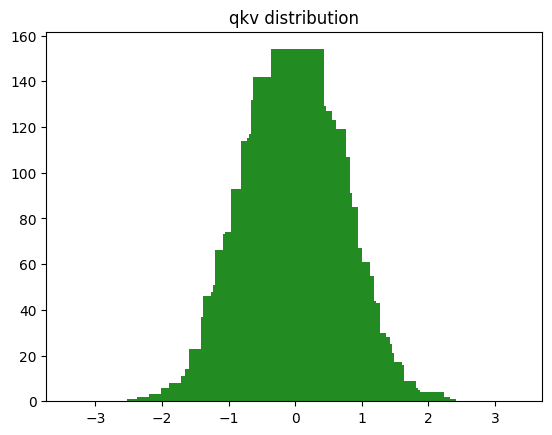

In [7]:
import matplotlib.pyplot as plt

y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color='forestgreen')
plt.title('qkv distribution');

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

qkv.shape

torch.Size([1, 4, 8, 192])

In [9]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3 * head_dim]

qkv.shape

torch.Size([1, 8, 4, 192])

In [10]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$

In [12]:
import math

d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [13]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [14]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 0.7365, -0.3431],
        [-0.4874, -2.2317],
        [ 0.6121, -0.8378]])

In [15]:
torch.transpose(y, 1, 0)

tensor([[ 0.7365, -0.3431],
        [-0.4874, -2.2317],
        [ 0.6121, -0.8378]])

In [16]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [18]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [20]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [21]:
(scaled + mask)[0][0]

tensor([[ 0.1183,    -inf,    -inf,    -inf],
        [ 0.1025,  0.2206,    -inf,    -inf],
        [ 0.6805,  0.0523,  0.5075,    -inf],
        [ 0.2214,  0.2996, -0.1913, -0.5682]], grad_fn=<SelectBackward0>)

In [22]:
np.exp(0.1025) / (np.exp(0.1025) + np.exp(0.2206))

0.4705092691356438

In [23]:
np.exp(0.2206) / (np.exp(0.1025) + np.exp(0.2206))

0.5294907308643562

In [24]:
scaled += mask

In [25]:
attention = F.softmax(scaled, dim=-1)

In [26]:
attention.shape

torch.Size([1, 8, 4, 4])

In [27]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4705, 0.5295, 0.0000, 0.0000],
        [0.4211, 0.2247, 0.3542, 0.0000],
        [0.3128, 0.3382, 0.2070, 0.1420]], grad_fn=<SelectBackward0>)

In [28]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [31]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [32]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [33]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4705, 0.5295, 0.0000, 0.0000],
        [0.4211, 0.2247, 0.3542, 0.0000],
        [0.3128, 0.3382, 0.2070, 0.1420]], grad_fn=<SelectBackward0>)

In [34]:
values.size()

torch.Size([1, 8, 4, 64])

In [35]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [36]:
linear_layer = nn.Linear(d_model, d_model)

out = linear_layer(values)

out.shape

torch.Size([1, 4, 512])

In [37]:
out

tensor([[[ 0.1429, -0.1624, -0.1575,  ...,  0.1823, -0.2781,  0.1793],
         [-0.2342, -0.0401,  0.0101,  ..., -0.2937, -0.2094,  0.0264],
         [ 0.0021,  0.0474,  0.0387,  ...,  0.3759, -0.1068,  0.3643],
         [ 0.3227,  0.2198,  0.0553,  ...,  0.3369,  0.2028,  0.0202]]],
       grad_fn=<ViewBackward0>)

## Class

In [40]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.shape: {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size: {attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

## Input

In [41]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.shape: torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size: torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
